In [10]:

import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
import h5py
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Data Processing

In [2]:
import data_processing
import PN_tools

In [3]:
 train_points_r, test_points_r, Y_train, Y_test = data_processing.load_data()

/datasets/home/home-01/25/125/a3mai/Pointnet/Prepdata
['ply_data_train4.h5', '.ipynb_checkpoints', 'ply_data_train2.h5', 'ply_data_train3.h5', 'ply_data_train1.h5', 'ply_data_train0.h5']
/datasets/home/home-01/25/125/a3mai/Pointnet/Prepdata_test
['.ipynb_checkpoints', 'ply_data_test1.h5', 'ply_data_test0.h5']


In [4]:
train_points_r.shape

(9840, 2048, 3)

# Model

In [5]:
import input_Tnet
import feature_Tnet

In [6]:

# number of points in each sample
num_points = train_points_r.shape[1]

# number of categories
k = 40

#  Pointnet Architecture
adam = optimizers.Adam(lr=0.001, decay=0.7)
input_points = Input(shape=(num_points, 3))

# T_net(transformation_net)
input_T = input_Tnet.Input_Tnet(num_points, input_points)

# Foward_net
fw = feature_Tnet.forward_net(input_T, input_points, num_points)

# T_net(transformation_net)
feature_T = feature_Tnet.feature_Tnet(fw, num_points)

# Forward net_v2
fw_v2 = feature_Tnet.forward_net_v2(feature_T, fw)

# Golobal_features
global_feature = MaxPooling1D(pool_size=num_points)(fw_v2)

# Convert pointnet to make prediction
a = Dense(512, activation='relu')(global_feature)
a = BatchNormalization()(a)
a = Dropout(rate=0.7)(a)
a = Dense(256, activation='relu')(a)
a = BatchNormalization()(a)
a = Dropout(rate=0.7)(a)
a = Dense(k, activation='softmax')(a)
prediction = Flatten()(a)


PN_model = Model(inputs=input_points, outputs=prediction)
print(PN_model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048, 64)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048, 64)          256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2048, 64)          0         
__________

# Training

In [7]:

PN_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
l_acc = np.zeros([1, 49])
l_val_acc = np.zeros([1, 49])
l_loss = np.zeros([1, 49])
l_val_loss = np.zeros([1, 49])

for i in range(1,50):
    train_points_rotate = PN_tools.rotate_point_cloud(train_points_r)
    train_points_jitter = PN_tools.jitter_point_cloud(train_points_rotate)
    history = PN_model.fit(train_points_jitter, Y_train, batch_size=32, validation_data = (test_points_r, Y_test), epochs=1, shuffle=True, verbose=1)
    s = "Current epoch is:" + str(i)
    l_acc[0, i-1] = history.history['acc'][0]
    l_val_acc[0, i-1] = history.history['val_acc'][0]
    l_loss[0, i-1] = history.history['loss'][0]
    l_val_loss[0, i-1] = history.history['val_loss'][0]
    
    
    
    print(s)
   
# score the model
score = PN_model.evaluate(test_points_r, Y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])


Train on 9840 samples, validate on 2468 samples
Epoch 1/1
9840/9840 [==============================] - 91s 9ms/step - loss: 3.2913 - acc: 0.2587 - val_loss: 1.9639 - val_acc: 0.4267
Current epoch is:1
Train on 9840 samples, validate on 2468 samples
Epoch 1/1
9840/9840 [==============================] - 86s 9ms/step - loss: 2.0873 - acc: 0.4240 - val_loss: 1.7717 - val_acc: 0.5207
Current epoch is:2
Train on 9840 samples, validate on 2468 samples
Epoch 1/1
9840/9840 [==============================] - 86s 9ms/step - loss: 1.7201 - acc: 0.5082 - val_loss: 1.7713 - val_acc: 0.5235
Current epoch is:3
Train on 9840 samples, validate on 2468 samples
Epoch 1/1
9840/9840 [==============================] - 86s 9ms/step - loss: 1.5450 - acc: 0.5507 - val_loss: 1.1764 - val_acc: 0.6447
Current epoch is:4
Train on 9840 samples, validate on 2468 samples
Epoch 1/1
9840/9840 [==============================] - 87s 9ms/step - loss: 1.4437 - acc: 0.5773 - val_loss: 1.3815 - val_acc: 0.5725
Current epoch 

In [15]:
l_acc.flatten().tolist()

[0.258739837398374,
 0.4239837398373984,
 0.5082317073170731,
 0.5507113821138211,
 0.5773373983739838,
 0.6014227642276423,
 0.6189024390243902,
 0.633739837398374,
 0.6376016260162601,
 0.646239837398374,
 0.6479674796747967,
 0.657520325203252,
 0.6602642276422764,
 0.6681910569105691,
 0.6755081300813008,
 0.6663617886178862,
 0.6651422764227642,
 0.679369918699187,
 0.6772357723577236,
 0.6816056910569106,
 0.6780487804878049,
 0.6834349593495935,
 0.6786585365853659,
 0.6878048780487804,
 0.691869918699187,
 0.6933943089430894,
 0.6978658536585366,
 0.6904471544715447,
 0.6936991869918699,
 0.6895325203252033,
 0.6882113821138212,
 0.6873983739837398,
 0.6952235772357723,
 0.6909552845528455,
 0.7005081300813009,
 0.7028455284552846,
 0.7058943089430895,
 0.7046747967479675,
 0.7117886178861789,
 0.7099593495934959,
 0.704979674796748,
 0.7095528455284553,
 0.7095528455284553,
 0.7088414634146342,
 0.7161585365853659,
 0.7173780487804878,
 0.7219512195121951,
 0.7163617886178861,

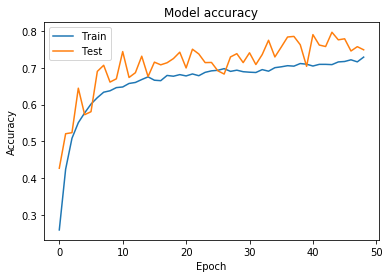

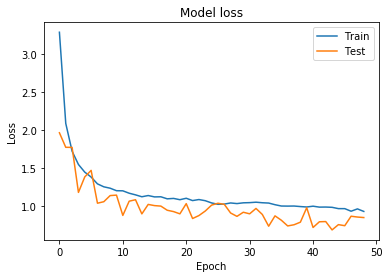

In [20]:
#Plot training & validation accuracy values
plt.plot(l_acc.flatten().tolist())
plt.plot(l_val_acc.flatten().tolist())
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('acc.png')
plt.show()

# Plot training & validation loss values
plt.plot(l_loss.flatten().tolist())
plt.plot(l_val_loss.flatten().tolist())
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('loss.png')
plt.show()


In [ ]:
PN_model.save("PN_model.h5")

In [84]:
t = PN_model.predict(test_points_r)

In [85]:
np.save('predict_pn1.npy', t)

In [86]:
np.save('test_point1.npy', test_points_r)

In [87]:
np.save('test_label1.npy', Y_test)